![](./img/chinahadoop.png)
# 互联网广告反欺诈建模-baseline解法
**[小象学院](http://www.chinahadoop.cn/course/landpage/15)《机器学习集训营》课程资料 by [@寒小阳](http://www.chinahadoop.cn/user/49339/about)**

- 对大量类别特征进行了Count/Rank编码处理
- 对长尾分布的特征有较好的表达
- 清洗了Model及Make,处理了长尾分布
- 全部大写
- 替换了url标识符
- 使用了Catboost建模

## 工具库引入

In [8]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 1000)
from pandas import DataFrame as DF
import scipy.spatial.distance as dist
import xgboost as xgb
import lightgbm as lgb
import catboost as cbt
import json
from sklearn.metrics import f1_score
import time
import gc
import math
from tqdm import tqdm
from scipy import stats
from sklearn.cluster import KMeans
from six.moves import reduce
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import warnings
warnings.filterwarnings('ignore')
get_ipython().run_line_magic('matplotlib', 'inline')

OSError: [WinError 126] 找不到指定的模块。

## 数据读取

In [3]:
train = pd.read_table("./data/round1_iflyad_anticheat_traindata.txt")
test = pd.read_table("./data/round1_iflyad_anticheat_testdata_feature.txt")
all_data = train.append(test).reset_index(drop=True)

In [4]:
train.head()

,sid,label,pkgname,ver,adunitshowid,mediashowid,apptype,nginxtime,ip,city,province,reqrealip,adidmd5,imeimd5,idfamd5,openudidmd5,macmd5,dvctype,model,make,ntt,carrier,os,osv,orientation,lan,h,w,ppi
0,d7460126-e071-4979-9ee8-42f72777a28a-156009070...,1,2d2664e827bcbb8b07100c7fbe072e9b,11.11.0,907d0f8c29663840491577a21c7b612a,ca64a500000d84c8fcb8a0587d0e1e0c,280.0,1.560091e+12,183.197.47.83,石家庄市,-1.0,180.76.181.7,eb4fa0cf77cdd57a6993a4e42c8fa4cf,930b3a8ecff4f586c63fec5b96693f32,empty,empty,ab96caaba2b7973e63fb0d3d5c5bf8b0,2.0,V1809A,vivo,2.0,46000.0,Android,8.1.0,0.0,zh-CN,2340.0,1080.0,3.0
1,b660d559-db97-4b5f-9bd2-2450cb89ce77-156005074...,1,empty,NaN,10199dc8fea2e173525bc3151bd84312,3f2fc57a6e1f9c6fa4464c25cc1e88a3,319.0,1.560051e+12,106.34.14.149,开封市,-1.0,47.95.111.138,a4ae6efcfaee62fb6da44a9c05753259,6e38deaa1f7b4118015c550bb21913d2,empty,a4ae6efcfaee62fb6da44a9c05753259,0f607264fc6318a92b9e13c65db7cd3c,2.0,BLA-AL00,HUAWEI,5.0,0.0,android,Android_9,0.0,NaN,1080.0,2040.0,0.0
2,f49a740e-66c3-4605-9b67-4d3079fe69cb-156008914...,0,16b81f93f4b1a35cebbf15f07683f171,3.2.1.0524.1958,83f2ecfe65f936f5f2ed59f8e8ff1d01,eea7280e1a2313e4c2e89290b01d196c,273.0,1.560089e+12,223.104.16.151,长春市,-1.0,39.96.159.155,3404f799628be2cf8fda7428aac2cca4,3fa42b06332c729f530b973973fabe3d,empty,empty,5ba1cf1efeee4f83e91f9c0adc3015e3,2.0,PBEM00,OPPO,2.0,46000.0,Android,8.1.0,1.0,zh-CN,2196.0,1080.0,0.0
3,fd60d096-f168-4540-b782-729d64d0fcc6-156006253...,0,empty,4.7.5,9f1eadd9092b19bc86ee0cacde1c867f,eec946a5a66c023ec9d3b2ede5900626,265.0,1.560063e+12,223.104.239.101,曲靖市,-1.0,47.101.65.230,941517d46b7261d98592425672bb86f5,04420edf96dde14c357db3e83d0b2310,empty,empty,empty,2.0,M711C,NaN,6.0,0.0,android,7.0,0.0,NaN,0.0,0.0,0.0
4,a037b032-a5c7-40ea-9161-26b118b12406-156007938...,1,cf4821986014a7fef9d7b7ad8de655e4,228,2af944462e43cd2f59acbbfd37445413,57b3053174973702549ba88b6017ac30,336.0,1.560079e+12,220.152.155.170,深圳市,-1.0,39.96.183.23,fc08a6724db4c2dcf9b5af3a4e0b6f38,23e94b65bab381bf57169149a20c0520,empty,empty,4363320019cbb7cde8b704908b673416,2.0,HUAWEI EML-AL00,EML-AL00,2.0,46000.0,Android,9,0.0,Zh-CN,2244.0,1080.0,0.0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 29 columns):
sid             1000000 non-null object
label           1000000 non-null int64
pkgname         1000000 non-null object
ver             678176 non-null object
adunitshowid    1000000 non-null object
mediashowid     1000000 non-null object
apptype         1000000 non-null float64
nginxtime       1000000 non-null float64
ip              1000000 non-null object
city            984807 non-null object
province        1000000 non-null float64
reqrealip       1000000 non-null object
adidmd5         1000000 non-null object
imeimd5         1000000 non-null object
idfamd5         1000000 non-null object
openudidmd5     1000000 non-null object
macmd5          1000000 non-null object
dvctype         1000000 non-null float64
model           995533 non-null object
make            876165 non-null object
ntt             1000000 non-null float64
carrier         1000000 non-null float64
os     

In [9]:
train.describe()

,label,apptype,nginxtime,province,dvctype,ntt,carrier,orientation,h,w,ppi
count,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,0.482894,296.176870,1.559815e+12,0.429006,1.636588,3.089714,40016.597331,0.279626,1264.178138,703.122219,71.740154
std,0.499708,42.996455,1.681617e+08,6.116586,0.814882,1.842680,15474.197096,1.040451,853.682627,506.047340,167.470664
min,0.000000,-1.000000,1.559491e+12,-1.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,273.000000,1.559664e+12,-1.000000,2.000000,2.000000,46000.000000,0.000000,720.000000,360.000000,0.000000
50%,0.000000,301.000000,1.559816e+12,-1.000000,2.000000,2.000000,46000.000000,0.000000,1280.000000,720.000000,0.000000
75%,1.000000,326.000000,1.559965e+12,-1.000000,2.000000,5.000000,46000.000000,1.000000,2040.000000,1080.000000,0.000000
max,1.000000,381.000000,1.560096e+12,34.000000,3.000000,7.000000,46003.000000,90.000000,9024.000000,9024.000000,720.000000


In [10]:
test.head()

,sid,pkgname,ver,adunitshowid,mediashowid,apptype,nginxtime,ip,city,province,reqrealip,adidmd5,imeimd5,idfamd5,openudidmd5,macmd5,dvctype,model,make,ntt,carrier,os,osv,orientation,lan,h,w,ppi
0,4601f528-865c-4238-a43f-cf4a4e11027d-156017418...,empty,190516,51f02f6007e49301adb4ccb1da0fbf12,5f83d3d963b19352aff3d9b5b29fa736,273.0,1.560174e+12,117.136.86.37,西安市,-1.0,120.132.53.176,9d87e5b432ac8f3048cf6ee38c867cfe,8be7e89c94848c14020a77aa175f6dbb,empty,empty,52cf13a05c72f6bd9167d622be314665,3.0,JKM-AL00,HUAWEI,6.0,46000.0,android,9,0.0,zh_CN,2137.0,1080.0,0.0
1,c727e4bf-2ae1-4829-9aa1-730277ee2042-156013863...,empty,4.2.0,96b536f3322df1404342c933fe597569,4d24206fcbc095ad0c27c7dd10e83047,318.0,1.560139e+12,110.52.34.129,株洲市,-1.0,139.199.129.29,3c24b405e9d0c055da356bbe991c4ded,5e5dd48daa023b3577269289faba142c,empty,empty,8396426c76002707ba8dde10297f3525,2.0,OPPO R9S PLUS,OPPO,2.0,46003.0,android,6.0,0.0,NaN,1080.0,1920.0,480.0
2,fe23d40a-0db8-403f-8df0-6e8b9ea461c3-156009638...,ae90f961dbafe0f78f8a1cd7775362ed,NaN,0d116d0416862dea0ff81905de4df513,fff9eaef85a611570dda886b390fee8a,281.0,1.560096e+12,120.229.25.233,深圳市,-1.0,123.123.219.25,7c0f4ff62a773520c11b5eb6dfba2d74,empty,empty,empty,empty,2.0,HUAWEI MLA-AL10,HUAWEI,2.0,-1.0,android,3.9.0,0.0,NaN,0.0,0.0,0.0
3,308b053c-5d7c-43b8-99dc-8aad647f953f-156017652...,empty,190516,51f02f6007e49301adb4ccb1da0fbf12,5f83d3d963b19352aff3d9b5b29fa736,273.0,1.560177e+12,117.136.19.239,无锡市,-1.0,117.50.25.7,f1604500eddb56dbd52d2a2ce2ca17e7,fa66fe6b853f069102faf3a55556102f,empty,empty,15cb635f22476ff6640f9f5f20262da8,3.0,PACT00,OPPO,6.0,46000.0,android,8.1.0,0.0,zh_CN,2280.0,1080.0,0.0
4,94477644-63cd-4f3c-9b2a-f3d25f1ec7e2-156014459...,170a88a12e36f8a0f1b73442304398b1,30927000,6618408bae888ad02c4e0d9bd4d88d29,d53d2af198ebef9544f0823c3c8e84f8,301.0,1.560145e+12,218.89.52.71,南充市,-1.0,39.96.159.161,empty,d7bdea1dc04a9cc31d180e40ea9b6110,empty,empty,5ba1cf1efeee4f83e91f9c0adc3015e3,2.0,OC105,SMARTISAN,2.0,46000.0,Android,7.1.2,1.0,zh-CN,720.0,360.0,0.0


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   sid           100000 non-null  object 
 1   pkgname       100000 non-null  object 
 2   ver           70808 non-null   object 
 3   adunitshowid  100000 non-null  object 
 4   mediashowid   100000 non-null  object 
 5   apptype       100000 non-null  float64
 6   nginxtime     100000 non-null  float64
 7   ip            100000 non-null  object 
 8   city          98533 non-null   object 
 9   province      100000 non-null  float64
 10  reqrealip     100000 non-null  object 
 11  adidmd5       100000 non-null  object 
 12  imeimd5       100000 non-null  object 
 13  idfamd5       100000 non-null  object 
 14  openudidmd5   100000 non-null  object 
 15  macmd5        100000 non-null  object 
 16  dvctype       100000 non-null  float64
 17  model         99905 non-null   object 
 18  make 

In [8]:
test.describe()

,apptype,nginxtime,province,dvctype,ntt,carrier,orientation,h,w,ppi
count,100000.000000,1.000000e+05,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,293.613590,1.560147e+12,0.52118,1.697870,3.208680,40043.255350,0.284220,1324.678060,726.281440,76.326330
std,42.307144,2.290188e+07,6.28967,0.793016,1.869681,15444.931973,1.185316,839.494123,488.670876,171.341531
min,-1.000000,1.560096e+12,-1.00000,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000
25%,273.000000,1.560131e+12,-1.00000,2.000000,2.000000,46000.000000,0.000000,760.000000,360.000000,0.000000
50%,301.000000,1.560150e+12,-1.00000,2.000000,2.000000,46000.000000,0.000000,1424.000000,720.000000,0.000000
75%,319.000000,1.560167e+12,-1.00000,2.000000,6.000000,46000.000000,1.000000,2130.000000,1080.000000,0.000000
max,381.000000,1.560182e+12,34.00000,3.000000,7.000000,46003.000000,90.000000,3180.000000,2960.000000,1000.000000


In [11]:
from datetime import timedelta, datetime # 处理时间戳数据
import time
 
import matplotlib.pyplot as plt  # 用于画图程序
import seaborn as sns
%matplotlib inline

sns.set(rc={'figure.figsize':(20,5)});
plt.figure(figsize=(20,5));

In [12]:
variables = ['pkgname', 'ver', 'adunitshowid', 'mediashowid', 'apptype', 'ip',
            'reqrealip', 'city', 'province', 'adidmd5', 'imeimd5', 'idfamd5',
            'openudidmd5', 'macmd5', 'dvctype', 'model', 'make', 'ntt',
            'carrier', 'os', 'osv', 'orientation', 'lan', 'h', 'w', 'ppi']

接下来我们统计一下数据集中，每个属性的的唯一值是多少？其实我看的baseline统计了的特征大多是每个属性中唯一值的个数，以及对结果进行排序。其实我想如果是这样的话，在训练数据中也可以增加一个特征，每一个属性值占总体的比例也可以试一下的。从结果中我们可以看到几个比较显著的特点：
- 有几个属性的唯一值比较的少，例如： 省  dvctype(设备类型)  厂商一类的
- 出现唯一值比较多的几个属性有，  IP地址  {(Adroid ID的MD5值)   mac的MD5值} 这两个属性可以表示是苹果设备还是安安卓设备。  imei的MD5值 (这个属性就不知道是啥意思了)
- 如果统计os的唯一值出现的次数的话，那么这一列的属性值就会很大，应该10万级别的，所以可不可以使用log以下结果。使得数据集中属性列之间的值差距不是很大。

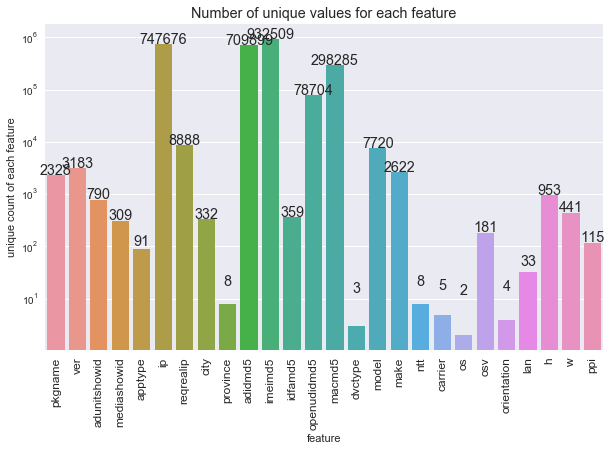

In [13]:
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90,fontsize=12)
uniques = [len(train[col].unique()) for col in variables]
sns.set(font_scale=1.2)
ax = sns.barplot(variables, uniques, log=True)
ax.set(xlabel='feature', ylabel='unique count of each feature', title='Number of unique values for each feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center")

接下来我们统计一下数据集中目标标签出现的次数，看看是否出现正负样本差距较大的情况，如果出现需要对数据进行重采样。我们看到数据集中作弊的数量占48%， 而负样本占52%。 所以不需要我们执行重采样。

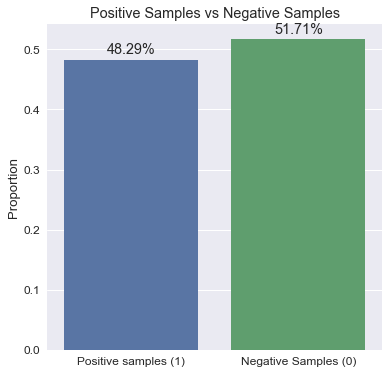

In [14]:
plt.figure(figsize=(6,6))
#sns.set(font_scale=1.2)  
 
mean = (train.label.values == 1).mean()
ax = sns.barplot(['Positive samples (1)', 'Negative Samples (0)'], [mean, 1-mean])
ax.set(ylabel='Proportion', title='Positive Samples vs Negative Samples')
for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center")

根据我们收集的资料我们可以知道对于是否作弊而言，IP地址应该是一个强特征，okay咱们开始分析一下IP地址和目标标签之间的关系。首先咱们先统计一下数据集中ip地址出现的次数。然后画图展示一下IP地址出现次数的大致分布。最后咱们分析一下IP地址和目标标签之间的关系。

In [15]:
temp = train['ip'].value_counts().reset_index(name='counts')
temp.columns = ['ip', 'counts']

数据集中前temp的值 <class 'pandas.core.frame.DataFrame'>


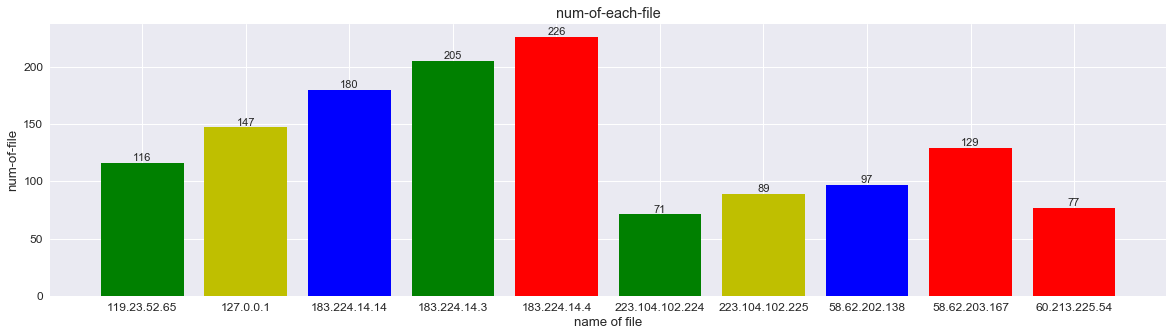

In [16]:
import matplotlib.pyplot as plt
import sys
 
print('数据集中前temp的值', type(temp))
name = list(temp['ip'].iloc[0:10])
num = list(temp['counts'].iloc[0:10])
 
plt.bar(name, num, color='rgby')
plt.xlabel('name of file')
plt.ylabel("num-of-file")
plt.title("num-of-each-file")
for a, b in zip(name, num):
 plt.text(a, b, '%.0f' % b, ha='center', va='bottom', fontsize=11)
 
plt.show()

IP地址出现的次数大多都是一次，最高的才出现了200多次，这个可以作为最后的新的特征。上面我们可以看到向os这样的属性值中，每一个属性可能出现上万次，然后在我们ip地址才出现200， 所以统计特征的时候是否有必要所有的特征都统计出现次数，是个问题。

IP地址出现的次数和是否下载之间的关系。蓝色先表示的某个IP地址的出现的次数，黄色的线表示数据中出现的次数作弊率还是挺高的，感觉上IP地址应该是个相对不错的特征对于这个模型。但是还是有疑问的。

In [17]:
# 将原始数据中的标签转化成int型数据
train['target']=train['label'].astype(int)

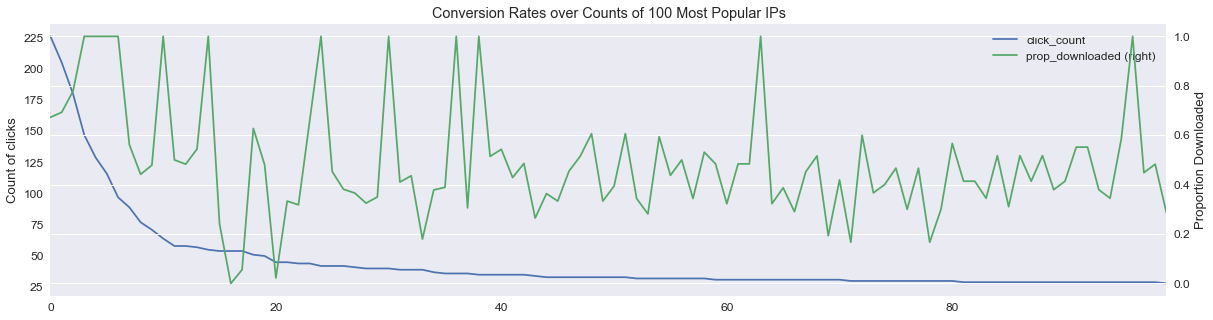

Counversion Rates over Counts of Most Popular IPs
                 ip  click_count  prop_downloaded
0      183.224.14.4          226         0.672566
1      183.224.14.3          205         0.692683
2     183.224.14.14          180         0.777778
3         127.0.0.1          147         1.000000
4     58.62.203.167          129         1.000000
5      119.23.52.65          116         1.000000
6     58.62.202.138           97         1.000000
7   223.104.102.225           89         0.561798
8     60.213.225.54           77         0.441558
9   223.104.102.224           71         0.478873
10    18.219.51.149           64         1.000000
11     112.47.34.12           58         0.500000
12    223.104.45.66           58         0.482759
13     112.47.34.14           57         0.543860
14     18.219.5.220           55         1.000000
15    42.101.64.215           54         0.240741
16  125.115.190.247           54         0.000000
17    42.101.64.100           54         0.055556


In [18]:
proportion = train[['ip', 'target']].groupby('ip', as_index=False).mean().sort_values('target', ascending=False)
counts = train[['ip', 'target']].groupby('ip', as_index=False).count().sort_values('target', ascending=False)
merge = counts.merge(proportion, on='ip', how='left')
merge.columns = ['ip', 'click_count', 'prop_downloaded']
 
ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular IPs')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()
 
print('Counversion Rates over Counts of Most Popular IPs')
print(merge[:20])

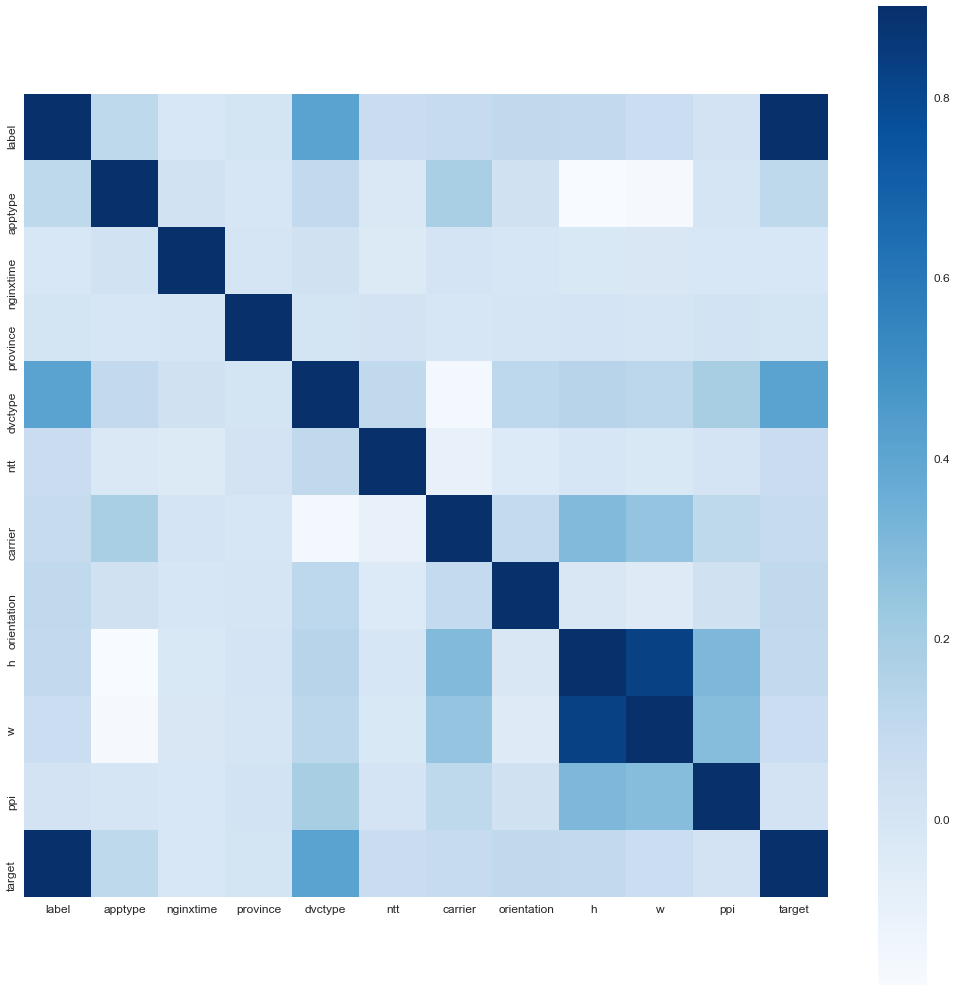

In [19]:
#相关性
corr = train.corr()
plt.subplots(figsize=(18,18))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)

## 数据处理与特征工程

In [20]:
# 对时间的处理
all_data['time'] = pd.to_datetime(all_data['nginxtime']*1e+6) + timedelta(hours=8)
all_data['day'] = all_data['time'].dt.dayofyear
all_data['hour'] = all_data['time'].dt.hour

In [21]:
all_data.head()

,adidmd5,adunitshowid,apptype,carrier,city,dvctype,h,idfamd5,imeimd5,ip,label,lan,macmd5,make,mediashowid,model,nginxtime,ntt,openudidmd5,orientation,os,osv,pkgname,ppi,province,reqrealip,sid,ver,w,time,day,hour
0,eb4fa0cf77cdd57a6993a4e42c8fa4cf,907d0f8c29663840491577a21c7b612a,280.0,46000.0,石家庄市,2.0,2340.0,empty,930b3a8ecff4f586c63fec5b96693f32,183.197.47.83,1.0,zh-CN,ab96caaba2b7973e63fb0d3d5c5bf8b0,vivo,ca64a500000d84c8fcb8a0587d0e1e0c,V1809A,1.560091e+12,2.0,empty,0.0,Android,8.1.0,2d2664e827bcbb8b07100c7fbe072e9b,3.0,-1.0,180.76.181.7,d7460126-e071-4979-9ee8-42f72777a28a-156009070...,11.11.0,1080.0,2019-06-09 22:31:41.087000064,160,22
1,a4ae6efcfaee62fb6da44a9c05753259,10199dc8fea2e173525bc3151bd84312,319.0,0.0,开封市,2.0,1080.0,empty,6e38deaa1f7b4118015c550bb21913d2,106.34.14.149,1.0,NaN,0f607264fc6318a92b9e13c65db7cd3c,HUAWEI,3f2fc57a6e1f9c6fa4464c25cc1e88a3,BLA-AL00,1.560051e+12,5.0,a4ae6efcfaee62fb6da44a9c05753259,0.0,android,Android_9,empty,0.0,-1.0,47.95.111.138,b660d559-db97-4b5f-9bd2-2450cb89ce77-156005074...,NaN,2040.0,2019-06-09 11:25:40.123000064,160,11
2,3404f799628be2cf8fda7428aac2cca4,83f2ecfe65f936f5f2ed59f8e8ff1d01,273.0,46000.0,长春市,2.0,2196.0,empty,3fa42b06332c729f530b973973fabe3d,223.104.16.151,0.0,zh-CN,5ba1cf1efeee4f83e91f9c0adc3015e3,OPPO,eea7280e1a2313e4c2e89290b01d196c,PBEM00,1.560089e+12,2.0,empty,1.0,Android,8.1.0,16b81f93f4b1a35cebbf15f07683f171,0.0,-1.0,39.96.159.155,f49a740e-66c3-4605-9b67-4d3079fe69cb-156008914...,3.2.1.0524.1958,1080.0,2019-06-09 22:05:45.217999872,160,22
3,941517d46b7261d98592425672bb86f5,9f1eadd9092b19bc86ee0cacde1c867f,265.0,0.0,曲靖市,2.0,0.0,empty,04420edf96dde14c357db3e83d0b2310,223.104.239.101,0.0,NaN,empty,NaN,eec946a5a66c023ec9d3b2ede5900626,M711C,1.560063e+12,6.0,empty,0.0,android,7.0,empty,0.0,-1.0,47.101.65.230,fd60d096-f168-4540-b782-729d64d0fcc6-156006253...,4.7.5,0.0,2019-06-09 14:42:19.740000000,160,14
4,fc08a6724db4c2dcf9b5af3a4e0b6f38,2af944462e43cd2f59acbbfd37445413,336.0,46000.0,深圳市,2.0,2244.0,empty,23e94b65bab381bf57169149a20c0520,220.152.155.170,1.0,Zh-CN,4363320019cbb7cde8b704908b673416,EML-AL00,57b3053174973702549ba88b6017ac30,HUAWEI EML-AL00,1.560079e+12,2.0,empty,0.0,Android,9,cf4821986014a7fef9d7b7ad8de655e4,0.0,-1.0,39.96.183.23,a037b032-a5c7-40ea-9161-26b118b12406-156007938...,228,1080.0,2019-06-09 19:23:00.271000064,160,19


In [22]:
all_data['model'].value_counts()

PBAM00                   29272
PACM00                   26127
PBEM00                   25024
PADM00                   15854
VIVO X21A                14682
MI 8                     14162
PBBM00                   13778
OPPO R9S                 12509
COL-AL10                 12001
VIVO Y85A                11997
OPPO A57                 11908
EML-AL00                 10426
PBAT00                   10124
V1813A                   10123
VIVO X20A                 9772
V1809A                    9492
PAR-AL00                  9052
VIVO X9                   8984
OPPO R11                  8857
PAAM00                    8718
PACT00                    7801
PBCM10                    7716
V1816A                    7657
V1818A                    6882
OS105                     6270
OPPO R9SK                 6141
OPPO R9M                  6100
OPPO A59S                 6018
VIVO X7                   6012
OPPO R11S                 5942
                         ...  
ZJ108-R9S                    1
BND-L21 

In [13]:
all_data['model'].value_counts().head(50)

PBAM00           29272
PACM00           26127
PBEM00           25024
PADM00           15854
VIVO X21A        14682
MI 8             14162
PBBM00           13778
OPPO R9S         12509
COL-AL10         12001
VIVO Y85A        11997
OPPO A57         11908
EML-AL00         10426
PBAT00           10124
V1813A           10123
VIVO X20A         9772
V1809A            9492
PAR-AL00          9052
VIVO X9           8984
OPPO R11          8857
PAAM00            8718
PACT00            7801
PBCM10            7716
V1816A            7657
V1818A            6882
OS105             6270
OPPO R9SK         6141
OPPO R9M          6100
OPPO A59S         6018
VIVO X7           6012
OPPO R11S         5942
HMA-AL00          5776
VIVO Y83A         5731
INE-AL00          5577
OPPO R9S PLUS     5538
VIVO Y66          5407
MHA-AL00          5352
PADT00            5219
CLT-AL00          5113
MI 8 LITE         5064
OD103             4949
JSN-AL00          4866
PBET00            4721
LYA-AL00          4690
MI 8 SE    

In [23]:
all_data['model'].dropna()[all_data['model'].dropna().str.contains("%")]

45                     OPPO%20R9S
299                       MIX%202
497                    OPPO%20A57
614                    OPPO%20A57
674                   VIVO%20Y85A
1376                   VIVO%20Z1I
1941                   REDMI%204X
2021                  OPPO%20A59S
2134              %2522OS105%2522
2211                  16TH%20PLUS
2474          %2522VIVO%2BX7%2522
2761                      MIX%202
3751                  VIVO%20Y85A
4067             REDMI%20NOTE%204
4115                       MI%208
4233                  VIVO%20X20A
4556                   VIVO%20Y66
4696       OPPO%20R9%20PLUSTM%20A
4794                MI%208%20LITE
4883             REDMI%20NOTE%204
4934                       M2%20E
5122                    NEXUS%205
5385                  OPPO%20A59S
5491              ONEPLUS%20A3000
5529                  OPPO%20A59S
5808            HUAWEI%20MLA-UL00
6393                  OPPO%20A83T
6602                    VIVO%20X7
6744              VIVO%20X21I%20A
7337          

In [24]:
# Data Clean
# 全部变成大写，防止oppo 和 OPPO 的出现
all_data['model'].replace('PACM00',"OPPO R15",inplace=True)
all_data['model'].replace('PBAM00',"OPPO A5",inplace=True)
all_data['model'].replace('PBEM00',"OPPO R17",inplace=True)
all_data['model'].replace('PADM00',"OPPO A3",inplace=True)
all_data['model'].replace('PBBM00',"OPPO A7",inplace=True)
all_data['model'].replace('PAAM00',"OPPO R15_1",inplace=True)
all_data['model'].replace('PACT00',"OPPO R15_2",inplace=True)
all_data['model'].replace('PABT00',"OPPO A5_1",inplace=True)
all_data['model'].replace('PBCM10',"OPPO R15x",inplace=True)

In [30]:
for fea in ['model','make','lan']:
    all_data[fea] = all_data[fea].astype('str')
    all_data[fea] = all_data[fea].map(lambda x:x.upper())

    from urllib.parse import unquote

    def url_clean(x):
        x = unquote(x,'utf-8').replace('%2B',' ').replace('%20',' ').replace('%2F','/').replace('%3F','?').replace('%25','%').replace('%23','#').replace(".",' ').replace('??',' ').\
                               replace('%26',' ').replace("%3D",'=').replace('%22','').replace('_',' ').replace('+',' ').replace('-',' ').replace('__',' ').replace('  ',' ').replace(',',' ')
        
        if (x[0]=='V') & (x[-1]=='A'):
            return "VIVO {}".format(x)
        elif (x[0]=='P') & (x[-1]=='0'):
            return "OPPO {}".format(x)
        elif (len(x)==5) & (x[0]=='O'):
            return "Smartisan {}".format(x)
        elif ('AL00' in x):
            return "HW {}".format(x)
        else:
            return x

    all_data[fea] = all_data[fea].map(url_clean)
    
all_data['big_model'] = all_data['model'].map(lambda x:x.split(' ')[0])
all_data['model_equal_make'] = (all_data['big_model']==all_data['make']).astype(int)

In [34]:
# H,W,PPI

all_data['size'] = (np.sqrt(all_data['h']**2 + all_data['w'] ** 2) / 2.54) / 1000
all_data['ratio'] = all_data['h'] / all_data['w']
all_data['px'] = all_data['ppi'] * all_data['size']
all_data['mj'] = all_data['h'] * all_data['w']

num_col = ['h','w','size','mj','ratio','px']
cat_col = [i for i in all_data.select_dtypes(object).columns if i not in ['sid','label']]
both_col = []

for i in tqdm(cat_col):
    lbl = LabelEncoder()
    all_data[i+"_count"] = all_data.groupby([i])[i].transform('count')
    all_data[i+"_rank"] = all_data[i+"_count"].rank(method='min')
    all_data[i] = lbl.fit_transform(all_data[i].astype(str))
    both_col.extend([i+"_count",i+"_rank"])

for i in tqdm(['h','w','ppi','ratio']):
    all_data['{}_count'.format(i)] = all_data.groupby(['{}'.format(i)])['sid'].transform('count')
    all_data['{}_rank'.format(i)] = all_data['{}_count'.format(i)].rank(method='min')

feature_name = [i for i in all_data.columns if i not in ['sid','label','time']]
cat_list = [i for i in train.columns if i not in ['sid','label','nginxtime']]

TypeError: include and exclude must both be non-string sequences

In [33]:
# H,W,PPI

all_data['size'] = (np.sqrt(all_data['h']**2 + all_data['w'] ** 2) / 2.54) / 1000
all_data['ratio'] = all_data['h'] / all_data['w']
all_data['px'] = all_data['ppi'] * all_data['size']
all_data['mj'] = all_data['h'] * all_data['w']

num_col = ['h','w','size','mj','ratio','px']
cat_col = [i for i in all_data.select_dtypes(object).columns if i not in ['sid','label']]
both_col = []

TypeError: include and exclude must both be non-string sequences

## 交叉验证切分建模集成
```
第 1，2，3，4，5折
训练集：1，2，3，4  验证集：5 => model1 => 预估X_test p(model1)
训练集：1，2，3，5  验证集：4 => model2 => 预估X_test p(model2)
训练集：1，2，4，5  验证集：3 => model3 => 预估X_test p(model3)
训练集：1，3，4，5  验证集：2 => model4 => 预估X_test p(model4)
训练集：5，2，3，4  验证集：1 => model5 => 预估X_test p(model5)
(p1+p2+p3+p4+p5)/5 = p
```

In [ ]:
from sklearn.metrics import roc_auc_score

tr_index = ~all_data['label'].isnull()
X_train = all_data[tr_index][list(set(feature_name))].reset_index(drop=True)
y = all_data[tr_index]['label'].reset_index(drop=True).astype(int)
X_test = all_data[~tr_index][list(set(feature_name))].reset_index(drop=True)
print(X_train.shape,X_test.shape)
random_seed = 2019
final_pred = []
cv_score = []
cv_model = []
skf = StratifiedKFold(n_splits=5, random_state=random_seed, shuffle=True)
for index, (train_index, test_index) in enumerate(skf.split(X_train, y)):
    print(index)
    train_x, test_x, train_y, test_y = X_train[feature_name].iloc[train_index], X_train[feature_name].iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    cbt_model = cbt.CatBoostClassifier(iterations=3000,learning_rate=0.05,max_depth=11,l2_leaf_reg=1,verbose=10,early_stopping_rounds=400,eval_metric='F1')
    cbt_model.fit(train_x[feature_name], train_y,eval_set=(test_x[feature_name],test_y))
    cv_model.append(cbt_model)
    y_test = cbt_model.predict(X_test[feature_name])
    y_val = cbt_model.predict_proba(test_x[feature_name])
    print(Counter(np.argmax(y_val,axis=1)))
    cv_score.append(f1_score(test_y,np.round(y_val[:,1])))

(1000000, 79) (100000, 79)
0
0:	learn: 0.8674992	test: 0.8681283	best: 0.8681283 (0)	total: 613ms	remaining: 30m 37s
10:	learn: 0.8927756	test: 0.8923268	best: 0.8923268 (10)	total: 5.66s	remaining: 25m 38s
20:	learn: 0.9053889	test: 0.9051804	best: 0.9051804 (20)	total: 10.6s	remaining: 25m 8s
30:	learn: 0.9116707	test: 0.9115882	best: 0.9115882 (30)	total: 15.5s	remaining: 24m 46s
40:	learn: 0.9142475	test: 0.9142626	best: 0.9142626 (40)	total: 20.6s	remaining: 24m 47s
50:	learn: 0.9185028	test: 0.9184575	best: 0.9184575 (50)	total: 25.5s	remaining: 24m 33s
60:	learn: 0.9214166	test: 0.9212619	best: 0.9212619 (60)	total: 30.4s	remaining: 24m 22s
70:	learn: 0.9236102	test: 0.9234059	best: 0.9234059 (70)	total: 35.5s	remaining: 24m 24s
80:	learn: 0.9262738	test: 0.9259620	best: 0.9259620 (80)	total: 40.5s	remaining: 24m 21s
90:	learn: 0.9273700	test: 0.9269191	best: 0.9269191 (90)	total: 45.8s	remaining: 24m 23s
100:	learn: 0.9282525	test: 0.9276668	best: 0.9276668 (100)	total: 51s	rem

In [ ]:
fi = []
for i in cv_model:
    tmp = {
        'name' : feature_name,
        'score' : i.feature_importances_
    }
    fi.append(pd.DataFrame(tmp))
    
fi = pd.concat(fi)
fig = plt.figure(figsize=(8,8))
fi.groupby(['name'])['score'].agg('mean').sort_values(ascending=False).head(40).plot.barh()

cv_pred = np.zeros((X_train.shape[0],))
test_pred = np.zeros((X_test.shape[0],))
for index, (train_index, test_index) in enumerate(skf.split(X_train, y)):
    print(index)
    train_x, test_x, train_y, test_y = X_train.iloc[train_index], X_train.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    y_val = cv_model[index].predict_proba(test_x[feature_name])[:,1]
    print(y_val.shape)
    cv_pred[test_index] = y_val
    test_pred += cv_model[index].predict_proba(X_test[feature_name])[:,1] / 5

print("CV score: ",np.mean(cv_score))

submit = test[['sid']]
submit['label'] = (test_pred>=0.5).astype(int)
print(submit['label'].value_counts())
submit.to_csv("submission.csv",index=False)